# Classification of patent documents

This code classifies patent documents according to their language. The provided patent documents belong to one of the following three technology fields: vehicle brakes (patent class F16D65/00), density determination (patent class G01N9/00) and insulin pumps (patent class A61M5/142).

## 1. Load necessary libraries

In [0]:
# if using google colab
%tensorflow_version 2.x

In [0]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
import collections
import time
import codecs

# crc, 12.3.2020, import additional modules for input preparation
import pandas as pd
import os
import shutil
import PIL
import PIL.Image
import PIL.ImageFont
import PIL.ImageOps
import PIL.ImageDraw
###########################################

from tensorflow import keras #frm

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 2. Prepare input text files
The input text files are generated from the Excel files which contain the text data for training and validation.

In [2]:
# crc, 12.3.2020
# We upload the Excel files from the local machine interactively.

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
#crc, 12.3.2020
# We read in the text data into pandas data frames.

dataframe_A61M5_145 = pd.read_excel('A61M5_145.xlsx',header=None)
dataframe_E04C3_04 = pd.read_excel('E04C3_04.xlsx',header=None)
dataframe_F25B30_00 = pd.read_excel('F25B30_00.xlsx',header=None)
dataframe_G01P7_00 = pd.read_excel('G01P7_00.xlsx',header=None)
dataframe_Noise = pd.read_excel('Noise.xlsx',header=None)

In [4]:
dataframe_A61M5_145.head()

,0
0,Infusion pump assembly for infusing e.g. infus...
1,Computer-implemented method for infusing insul...
2,Cassette for use in surgical fluid management ...
3,Apparatus i.e. spring powered ambulatory infus...
4,Flexible reservoir system for storing liquid d...


In [0]:
# crc, 12.3.2020
# We convert the pandas data frames into numpy arrays for easier manipulation.

data_A61M5_145 = np.array(dataframe_A61M5_145)
data_E04C3_04 = np.array(dataframe_E04C3_04)
data_F25B30_00 = np.array(dataframe_F25B30_00)
data_G01P7_00 = np.array(dataframe_G01P7_00)
data_Noise = np.array(dataframe_Noise)

In [0]:
# crc, 12.3.2020
# We join all text data in order to build raw dictionary data.

data_dictionary = np.concatenate((data_A61M5_145,data_E04C3_04,data_F25B30_00,data_G01P7_00,data_Noise))   

In [0]:
# crc, 12.3.2020
# We clean all previously generated text files and their folders

current_directory = os.getcwd()
with os.scandir(current_directory) as it:
    for entry in it:
        if entry.name == 'A61M5_145_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'E04C3_04_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'F25B30_00_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'G01P7_00_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'Noise_txt':
            shutil.rmtree(entry.name)



        if entry.name == 'A61M5_142_dump_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'G01N9_00_dump_txt':
            shutil.rmtree(entry.name)
        if entry.name == 'F16D65_00_dump_txt':
            shutil.rmtree(entry.name)

In [0]:
# crc, 12.3.2020
# We create folders for text files

os.mkdir('A61M5_145_txt')
os.mkdir('E04C3_04_txt')
os.mkdir('F25B30_00_txt')
os.mkdir('G01P7_00_txt')
os.mkdir('Noise_txt')

In [0]:
# crc, 12.3.2020
# We create a text file for every text cell in the Excel files

for i in range(len(data_A61M5_145)):
    np.savetxt('A61M5_145_txt/claims_A61M5_145_{0:d}.txt'.format(i),data_A61M5_145[i],fmt='%s',newline='')
    path_txt = 'A61M5_145_txt/claims_A61M5_145_{0:d}.txt'.format(i)
for i in range(len(data_E04C3_04)):
    np.savetxt('E04C3_04_txt/claims_E04C3_04_{0:d}.txt'.format(i),data_E04C3_04[i],fmt='%s',newline='')
    path_txt = 'E04C3_04_txt/claims_E04C3_04_{0:d}.txt'.format(i)
for i in range(len(data_F25B30_00)):
    np.savetxt('F25B30_00_txt/claims_F25B30_00_{0:d}.txt'.format(i),data_F25B30_00[i],fmt='%s',newline='')
    path_txt = 'F25B30_00_txt/claims_F25B30_00_{0:d}.txt'.format(i)
for i in range(len(data_G01P7_00)):
    np.savetxt('G01P7_00_txt/claims_G01P7_00_{0:d}.txt'.format(i),data_G01P7_00[i],fmt='%s',newline='')
    path_txt = 'G01P7_00_txt/claims_G01P7_00_{0:d}.txt'.format(i)
for i in range(len(data_Noise)):
    np.savetxt('Noise_txt/claims_Noise_{0:d}.txt'.format(i),data_Noise[i],fmt='%s',newline='')
    path_txt = 'Noise_txt/claims_Noise_{0:d}.txt'.format(i)

In [0]:
# crc, 12.3.2020
# We clean the directory for the dictionary text data.

current_directory = os.getcwd()
with os.scandir(current_directory) as it:
    for entry in it:
        if entry.name == 'dictionary_txt':
            shutil.rmtree(entry.name)

In [0]:
# crc, 12.3.2020
# We create the directory for the dictionary text data.

os.mkdir('dictionary_txt')

In [0]:
# crc, 12.3.2020
# We dump all claims in one text file to create the dictionary text data.

np.savetxt('dictionary_txt/dictionary.txt',data_dictionary,fmt='%s',newline=' ')

## 3. Load the text data

In [0]:
#This function from Tutorial VI reads input text data, splits them into words and saves the words in to a Numpy array.

def read_data(fname):
    with codecs.open(fname, 'r', encoding='utf-8',
                 errors='ignore') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [word for i in range(len(content)) for word in content[i].split()]
    content = np.array(content)
    return content

In [0]:
text_label = ['A61M5_145', 'E04C3_04', 'F25B30_00', 'G01P7_00', 'Noise']

In [0]:
# We read text data for use in dictionary creation.
# Text for all technology fields including stop words.

text_dictionary_sw = read_data('dictionary_txt/dictionary.txt')

## 4. Build dataset
We will assign an id to each word, and make dictionaries word->id and id->word.
The most frequently repeating words have lowest id

In [0]:
# This function builds the dictionary including stop words.

def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)

    ############################################frm
    dictionary = {k:(v+2) for k, v in dictionary.items()}
    dictionary["<unk>"] = 1 #Padding = Füllstoff :-)
    dictionary["<pad>"] = 0 #Brauchen wir vielleicht nicht
    ############################################frm


    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary, count
   

In [0]:
# We generate the  dictionary for all technology fields.

dictionary = {}

dictionary_sw, reverse_dictionary_sw, count = build_dataset(text_dictionary_sw)
vocab_size = len(dictionary_sw)


In [18]:
# Added for debugging.

print(dictionary_sw)
print(reverse_dictionary_sw)

{'the': 2, 'of': 3, 'a': 4, 'and': 5, 'to': 6, 'said': 7, 'The': 8, 'in': 9, 'claim': 10, 'is': 11, 'wherein': 12, 'first': 13, 'second': 14, 'an': 15, 'for': 16, 'at': 17, 'with': 18, 'from': 19, 'one': 20, ':': 21, 'heat': 22, 'least': 23, 'or': 24, 'system': 25, 'that': 26, 'fluid': 27, 'A': 28, 'optical': 29, 'device': 30, 'method': 31, 'by': 32, 'as': 33, 'portion': 34, 'on': 35, 'having': 36, 'further': 37, 'are': 38, 'comprising': 39, 'between': 40, 'end': 41, 'each': 42, 'according': 43, 'plurality': 44, '1,': 45, 'light': 46, 'comprises': 47, 'pump': 48, 'member': 49, 'which': 50, 'side': 51, 'surface': 52, 'has': 53, 'comprising:': 54, 'through': 55, 'assembly': 56, 'being': 57, 'configured': 58, 'control': 59, 'into': 60, 'apparatus': 61, 'fiber': 62, 'flow': 63, 'be': 64, 'includes': 65, 'refrigerant': 66, 'within': 67, 'wall': 68, 'unit': 69, 'connected': 70, 'when': 71, '1': 72, 'means': 73, 'third': 74, 'support': 75, 'than': 76, 'two': 77, 'housing': 78, 'disposed': 79,

In [0]:
# We remove stop words from the dictionary and a reverse dictionary.
# The reverse dictionary is useful for debugging.

stop_words = {'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be',
 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do',
 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has',
 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't",
 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves',
 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some', 'such',
 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to',
 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while',
 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
 'yourself', 'yourselves'}

dictionary = {}

for i in dictionary_sw:
    if i.lower() not in stop_words:
        dictionary[i.lower()] = dictionary_sw[i]  # all words are in low characters.
x = len(dictionary)

reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))  


In [20]:
# Added for debugging.

print(dictionary)
print(reverse_dictionary)

{'said': 11565, 'claim': 5827, 'wherein': 11613, 'first': 2584, 'second': 3151, 'one': 3366, ':': 21, 'heat': 1508, 'least': 29905, 'system': 36524, 'fluid': 1802, 'optical': 694, 'device': 2611, 'method': 30052, 'portion': 34, 'comprising': 39, 'end': 3924, 'according': 39337, 'plurality': 44, '1,': 45, 'light': 1522, 'comprises': 46027, 'pump': 3491, 'member': 18752, 'side': 5103, 'surface': 6633, 'comprising:': 54, 'assembly': 7020, 'configured': 58, 'control': 19818, 'apparatus': 1269, 'fiber': 3004, 'flow': 8333, 'includes': 13857, 'refrigerant': 12958, 'within': 67, 'wall': 5604, 'unit': 9979, 'connected': 70, '1': 72, 'means': 18900, 'third': 9526, 'support': 3376, 'two': 4831, 'housing': 2879, 'disposed': 79, 'beam': 4485, 'extending': 81, 'water': 7359, 'pressure': 5927, 'material': 21840, 'temperature': 21846, 'including': 86, 'formed': 87, 'element': 88, 'reservoir': 3490, 'structure': 33071, 'coupled': 92, 'body': 10684, 'delivery': 4368, 'exchanger': 36115, 'channel': 6171

In [0]:
# We read the text files and label them.

sample_number = 250      # the number of text files to use
fw = 350 #frm: Anzahl der Wörter in einerm Dokument

labels_A61M5_145 = []
texts_A61M5_145 = []
labels_E04C3_04 = []
texts_E04C3_04 = []
labels_F25B30_00 = []
texts_F25B30_00 = []
labels_G01P7_00 = []
texts_G01P7_00 = []
labels_Noise = []
texts_Noise = []

#A61M5_145
for sample in range(sample_number):
  text_sw = read_data('A61M5_145_txt/claims_A61M5_145_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_A61M5_145.append(text)
  labels_A61M5_145.append([1,0,0,0,0])

#E04C3_04
for sample in range(sample_number):
  text_sw = read_data('E04C3_04_txt/claims_E04C3_04_%d.txt'%sample)
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_E04C3_04.append(text)
  labels_E04C3_04.append([0,1,0,0,0])   

#F25B30_00
for sample in range(sample_number):
  text_sw = read_data('F25B30_00_txt/claims_F25B30_00_%d.txt'%sample)
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_F25B30_00.append(text)
  labels_F25B30_00.append([0,0,1,0,0])

#G01P7_00
for sample in range(sample_number):
  text_sw = read_data('G01P7_00_txt/claims_G01P7_00_%d.txt'%sample)
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_G01P7_00.append(text)
  labels_G01P7_00.append([0,0,0,1,0]) 

#Noise
for sample in range(sample_number):
  text_sw = read_data('Noise_txt/claims_Noise_%d.txt'%sample)
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_Noise.append(text)
  labels_Noise.append([0,0,0,0,1]) 

Then the whole text will look as a sequence of word ids:

In [0]:
# We convert the texts to numerical vector representation and save them in lists.
# Using the if statement we ignore words in the text which are not in the dictionary and avoid execution errors.

#A61M5_145
words_as_int_A61M5_145 = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_A61M5_145[sample] if w in dictionary]
  words_as_int_A61M5_145.append(words_as_int)

#E04C3_04

words_as_int_E04C3_04 = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_E04C3_04[sample] if w in dictionary]
  words_as_int_E04C3_04.append(words_as_int)

#F25B30_00

words_as_int_F25B30_00 = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_F25B30_00[sample] if w in dictionary]
  words_as_int_F25B30_00.append(words_as_int)

#G01P7_00

words_as_int_G01P7_00 = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_G01P7_00[sample] if w in dictionary]
  words_as_int_G01P7_00.append(words_as_int)

#Noise

words_as_int_Noise = []
words_as_int = []
for sample in range(sample_number):
  words_as_int = [dictionary[w] for w in texts_Noise[sample] if w in dictionary]
  words_as_int_Noise.append(words_as_int)

In [0]:
# We trim the word sequences to 250 words.


#A61M5_145
words_as_int_A61M5_145 = keras.preprocessing.sequence.pad_sequences(words_as_int_A61M5_145, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)
#E04C3_04
words_as_int_E04C3_04 = keras.preprocessing.sequence.pad_sequences(words_as_int_E04C3_04, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)
#F25B30_00
words_as_int_F25B30_00 = keras.preprocessing.sequence.pad_sequences(words_as_int_F25B30_00, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)
#G01P7_00
words_as_int_G01P7_00 = keras.preprocessing.sequence.pad_sequences(words_as_int_G01P7_00, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)
#Noise
words_as_int_Noise = keras.preprocessing.sequence.pad_sequences(words_as_int_Noise, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

In [112]:
# Added for debugging purposes: we test conversion of words into integers for individual text files.

words_as_int = []
words_as_int = [dictionary[w] for w in texts_A61M5_145[0] if w in dictionary]
words_as_int = keras.preprocessing.sequence.pad_sequences([words_as_int], value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

print(texts_A61M5_145[0][0:10])
for i in range(10):
  print(reverse_dictionary[words_as_int[0][i]])

['infusion', 'pump', 'assembly', 'infusing', 'e.g.', 'infusible', 'fluid,', 'e.g.', 'body', 'part,']
infusion
pump
assembly
infusing
e.g.
infusible
fluid,
e.g.
body
part,


In [113]:
words_as_int_A61M5_145[0]

array([ 2555,  3491,  7020, 31958, 15601, 17360,   746, 15601, 10684,
        1367,  1703,  7302,  1747,  1977, 12083, 17988,  4036, 17988,
         349,  3769, 11491,  5289,  9409, 25541, 20121,   139,  2555,
        3491,  7020,    54,  7302, 10420,  3491,  9223, 23293,  3491,
        9223,   558, 11565,  3491,  9223,  5154,  3490,  7020,    39,
        3490,  3769,  7262,  7302,  1747,  7895, 11565,  3491,  5716,
       11565,  7302,  1747,  3008, 11541, 11565,  3769, 11491, 29905,
        3366,  7302, 11392,  9750, 11565,  7302,  1747,  1444, 39240,
       11565,  7302,  8710, 11613, 11565,  7302, 11392,  1539, 23015,
       11565,  7302, 11392,  9750, 11613, 11565,  3490,  1230, 11565,
        7302, 11392,  1633, 17988,  2578, 17988, 11565,  3769, 11491,
         608, 11565,  3008,  2509, 11613, 11565,  7302,  1747,  2306,
       18104, 20121,   609, 11565,  3490, 37846, 11565,  7302,  1747,
       42308, 12083, 17988,  4036, 17988,   349, 11565,  3769, 11491,
        5289,  3638,

In [0]:
# We convert the list of lists containing the word ids into stacked arrays. This is needed for using data for model training and validation.

words_as_int_A61M5_145_array = words_as_int_A61M5_145[0]     #array initialization
words_as_int_E04C3_04_array = words_as_int_E04C3_04[0]
words_as_int_F25B30_00_array = words_as_int_F25B30_00[0]
words_as_int_G01P7_00_array = words_as_int_G01P7_00[0]
words_as_int_Noise_array = words_as_int_Noise[0]

for sample in range(1,sample_number):
  words_as_int_A61M5_145_array = np.vstack((words_as_int_A61M5_145_array,words_as_int_A61M5_145[sample]))
  words_as_int_E04C3_04_array = np.vstack((words_as_int_E04C3_04_array,words_as_int_E04C3_04[sample]))
  words_as_int_F25B30_00_array = np.vstack((words_as_int_F25B30_00_array,words_as_int_F25B30_00[sample]))
  words_as_int_G01P7_00_array = np.vstack((words_as_int_G01P7_00_array,words_as_int_G01P7_00[sample]))
  words_as_int_Noise_array = np.vstack((words_as_int_Noise_array,words_as_int_Noise[sample]))

## 5. Build model

We will build the model in TF2.
It contains one embedding layer, one pooling layer, three hidden dense layers and one dense output layer. The output layer includes three units corresponding to the technology fields.

In [115]:
# We define and compile the model.

model = keras.Sequential()
model.add(keras.layers.Embedding(2*x,16)) 
model.add(keras.layers.GlobalAveragePooling1D()) #vereinfacht/reduziert den Input aus dem Embedding-Layer

model.add(keras.layers.Dense(32,  activation = "relu"))
model.add(keras.layers.Dense(16,  activation = "relu"))
#model.add(keras.layers.Dense(16,  activation = "relu")) 
#model.add(keras.layers.Dense(8,  activation = "sigmoid"))
model.add(keras.layers.Dense(5,  activation = "softmax", name='classification_layer')) 

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0 = model.get_weights()  # saves the model weights
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          1402368   
_________________________________________________________________
global_average_pooling1d_8 ( (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
classification_layer (Dense) (None, 5)                 85        
Total params: 1,403,525
Trainable params: 1,403,525
Non-trainable params: 0
_________________________________________________________________


## Train

We build the training and validation data sets at a ratio of 9:1 and train the model.

In [116]:
ratio = 0.8   #ratio of training to validation data
n_train = int(sample_number*ratio)

# We generate the training and validation text sets

text_train = np.concatenate((words_as_int_A61M5_145_array[:n_train],words_as_int_E04C3_04_array[:n_train],words_as_int_F25B30_00_array[:n_train],words_as_int_G01P7_00_array[:n_train],words_as_int_Noise_array[:n_train]))
text_validation = np.concatenate((words_as_int_A61M5_145_array[n_train:,:],words_as_int_E04C3_04_array[n_train:,:],words_as_int_F25B30_00_array[n_train:,:],words_as_int_G01P7_00_array[n_train:,:],words_as_int_Noise_array[n_train:,:]))

# We convert the label lists into arrays

labels_A61M5_145 = np.array(labels_A61M5_145)
labels_E04C3_04 = np.array(labels_E04C3_04)
labels_F25B30_00 = np.array(labels_F25B30_00)
labels_G01P7_00 = np.array(labels_G01P7_00)
labels_Noise = np.array(labels_Noise)

labels_train = np.concatenate((labels_A61M5_145[:n_train],labels_E04C3_04[:n_train],labels_F25B30_00[:n_train],labels_G01P7_00[:n_train],labels_Noise[:n_train]))
labels_validation = np.concatenate((labels_A61M5_145[n_train:],labels_E04C3_04[n_train:],labels_F25B30_00[n_train:],labels_G01P7_00[n_train:],labels_Noise[n_train:]))

model.set_weights(W0)
training_history = model.fit(text_train,labels_train,batch_size=10,epochs=10,validation_data=(text_validation,labels_validation))

Epoch 1/10
100/100 [==============================] - 1s 11ms/step - loss: 1.5913 - accuracy: 0.3380 - val_loss: 1.5464 - val_accuracy: 0.4800
Epoch 2/10
100/100 [==============================] - 1s 10ms/step - loss: 1.3722 - accuracy: 0.5730 - val_loss: 1.1841 - val_accuracy: 0.6840
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 0.8634 - accuracy: 0.7790 - val_loss: 0.7802 - val_accuracy: 0.7720
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.4505 - accuracy: 0.9320 - val_loss: 0.5543 - val_accuracy: 0.8400
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.2175 - accuracy: 0.9780 - val_loss: 0.4663 - val_accuracy: 0.8640
Epoch 6/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1124 - accuracy: 0.9880 - val_loss: 0.4417 - val_accuracy: 0.8600
Epoch 7/10
100/100 [==============================] - 1s 10ms/step - loss: 0.0623 - accuracy: 0.9920 - val_loss: 0.4548 - val_accuracy: 0.8400

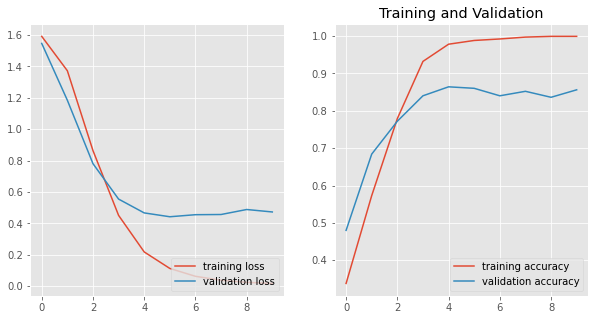

In [117]:
# We plot the training history

fig, axs = plt.subplots(1, 2, figsize=(10,5))
plt.title('Training and Validation')
axs[0].plot(training_history.epoch, training_history.history['loss'])
axs[0].plot(training_history.epoch, training_history.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(training_history.epoch, training_history.history['accuracy'])
axs[1].plot(training_history.epoch, training_history.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.savefig("Training_and_Validation.png")
plt.show()

In [0]:
# This function converts an arbitrary text into word ids.
def patent_encode(s):
  encoded = []

  for word in s:
    if word.lower() in dictionary:
      encoded.append(dictionary[word.lower()])

  return encoded

**Inference**

We infere patent classes for claims which were neither used for training nor for validation.

In [119]:
# This is the inference part. We predict the technology field for inputs which were not used either for training or validation.
# We use the read_data function to read in text and split the text into words. 

contents_sw = read_data("A61M5_145_txt/claims_A61M5_145_260.txt")   # reads stop words, too.

contents = []      # initializes this variable each time before removing stop words from texts 
for word in contents_sw:
  if word.lower() not in stop_words:      # removes stop words from text
    contents.append(word.lower())


encode = []     #initializes the variables for saving the encoding

encode = patent_encode(contents)    # converts text to word ids.
encode = keras.preprocessing.sequence.pad_sequences([encode], value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

# Added for debugging purposes.
# We print the first 10 words of the input text, the corresponding encoding and the reverse translation.

print(contents[0:9])

for i in range(9):
 print(encode[0][i])
 print(reverse_dictionary[encode[0][i]])

 ###############################################

predict = model.predict(encode)       # predicts technology field

print(predict[0]) 

# prediction output
# modified by crc on 25 April 2020.

if predict[0][0]>0.5:       
  print("Es handelt sich um ein Patent im Bereich Insulinpumpen.")
elif predict[0][1]>0.5:
  print("Es handelt sich um ein Patent im Bereich Metallprofilträger.")
elif predict[0][2]>0.5:
  print("Es handelt sich um ein Patent im Bereich Wärmepumpen.")
elif predict[0][3]>0.5:
  print("Es handelt sich um ein Patent im Bereich Geschwindigkeitsmessung.")
elif predict[0][3]>0.5:
  print("Es handelt sich um ein Patent aus der Rauschgruppe.")
else:
  print("Keine Kategorie erkannt")

['single-use', 'therapeutic', 'substance', 'delivery', 'device', 'medical', 'application,', 'micro', 'electro-mechanical']
21538
single-use
8734
therapeutic
13660
substance
4368
delivery
2611
device
4819
medical
4000
application,
9400
micro
13872
electro-mechanical
[1.00e+00 1.10e-06 4.29e-11 2.84e-05 3.36e-05]
Es handelt sich um ein Patent im Bereich Insulinpumpen.


In [120]:
#Test frm
# This is the inference part. We predict the technology field for inputs which were not used either for training or validation.
# We use the read_data function to read in text and split the text into words. 

for i in range(250,len(data_A61M5_145),1):
  
  contents_sw = read_data("A61M5_145_txt/claims_A61M5_145_{0:d}.txt".format(i))   # reads stop words, too.

  contents = []      # initializes this variable each time before removing stop words from texts 
  for word in contents_sw:
    if word.lower() not in stop_words:      # removes stop words from text
     contents.append(word.lower())


  encode = []     #initializes the variables for saving the encoding

  encode = patent_encode(contents)    # converts text to word ids.
  encode = keras.preprocessing.sequence.pad_sequences([encode], value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

# Added for debugging purposes.
# We print the first 10 words of the input text, the corresponding encoding and the reverse translation.


 ###############################################

  predict = model.predict(encode)       # predicts technology field

  print(predict[0]) 

# prediction output

  # modified by crc on 25 April 2020.

  if predict[0][0]>0.5:       
    print("Es handelt sich um ein Patent im Bereich Insulinpumpen.")
  elif predict[0][1]>0.5:
    print("Es handelt sich um ein Patent im Bereich Metallprofilträger.")
  elif predict[0][2]>0.5:
    print("Es handelt sich um ein Patent im Bereich Wärmepumpen.")
  elif predict[0][3]>0.5:
    print("Es handelt sich um ein Patent im Bereich Geschwindigkeitsmessung.")
  elif predict[0][3]>0.5:
    print("Es handelt sich um ein Patent aus der Rauschgruppe.")
  else:
    print("Keine Kategorie erkannt")

[1.00e+00 8.13e-06 7.81e-10 8.87e-05 1.07e-04]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[9.49e-01 7.87e-03 2.54e-06 1.07e-03 4.17e-02]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[8.68e-01 5.10e-03 3.85e-05 1.27e-02 1.15e-01]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[9.88e-01 9.80e-05 4.82e-07 3.97e-03 7.86e-03]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[9.92e-01 5.21e-05 2.54e-07 2.53e-03 5.67e-03]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[9.20e-01 1.16e-02 7.26e-06 2.05e-03 6.64e-02]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[9.03e-01 2.97e-04 1.11e-05 1.91e-02 7.76e-02]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[9.96e-01 2.43e-04 1.11e-07 6.53e-04 3.35e-03]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[8.34e-01 3.98e-04 3.17e-05 3.88e-02 1.27e-01]
Es handelt sich um ein Patent im Bereich Insulinpumpen.
[9.99e-01 4.49e-04 1.58e-09 2.19e-05 3.78e-04]
Es handelt sich um ein Pat

In [0]:
#frm Diese Zelle funktioniert nicht

#for i in range(100, 120,1):
#  with open("F16D65_00_txt/claims_F16D65_00_{0:d}.txt".format(i)) as f:
#    encode = []
#    for line in f.readlines():
#     # nline = line.replace(",","").replace(".","").replace("(,)","").replace(")","").replace(":","").strip().split()
#      nline = line.strip().split()
#      encode = patent_encode(nline)
#      encode = keras.preprocessing.sequence.pad_sequences([encode], value=dictionary["<pad>"], padding="post", maxlen=fw)
## Hier könnte man gleich einbauen, dass das Dokument, hier die "Testdatei.txt" direkt vom gelernten Modell klassiert wird
#  predict = model.predict(encode)
#  #print(line)
#  #print(encode)
#  print(predict[0]) 
#  print(i)
#  if predict[0][0]>0.5:
#    print("Es handelt sich um ein Patent im Bereich Fahrzeugbremsen")
#  elif predict[0][1]>0.5:
#    print("Es handelt sich um ein Patent im Bereich Dichtebestimmung")
#  elif predict[0][2]>0.5:
#    print("Es handelt sich um ein Patent im Bereich Insulinpumpen")
#  else:
#    print("Keine Kategorie erkannt")

In [122]:
# We save the model for inference.

!rm -r inference_model      # we delete any older model versions.
tf.saved_model.save(model, "inference_model")   # we save the current model version.

INFO:tensorflow:Assets written to: inference_model/assets


We create a wrapper for inference using the saved model as in Tutorial V.

In [0]:
class Inferer:
  def __init__(self, model_path, output_name):
    self.mod = tf.saved_model.load(model_path)
    self.func = self.mod.signatures["serving_default"]
    self.output_name = output_name
    self.class_names = np.array(['A61M5_145', 'E04C3_04', 'F25B30_00', 'G01P7_00', 'Noise'])
    self.max_len = 64 #frm: Was sagt die Zahl 64?

  def infere_class_batch(self, inputs):
    probabilities = self.func(tf.constant(inputs))[self.output_name].numpy()
    classes = np.argmax(probabilities, axis=1) #Maximum - Vorhersage des Modells
    probs = probabilities[np.arange(len(classes)), classes]
    return classes, probs

  def infere_class(self, inputs):
    n = len(inputs)
    if n > self.max_len:
      classes = []
      probs = []
      for i in range( (n+self.max_len-1) // self.max_len):
        batch = inputs[i* self.max_len : (i+1)* self.max_len]
        batch_classes, batch_probs = self.infere_class_batch(batch)
        classes.append(batch_classes)
        probs.append(batch_probs)
      classes = np.concatenate(classes)
      probs = np.concatenate(probs)
    else:
      classes, probs = self.infere_class_batch(inputs)

    return classes, probs

  def infere(self, inputs, prob=False):
    classes, probs = self.infere_class(inputs)
    cn = self.class_names[classes]
    return (cn, probs) if prob else cn

In [0]:
# We create an instance of the class Inferer

inf = Inferer('inference_model', model.output_names[0])

In [0]:
# We clean all previously generated inference text files and their folders

current_directory = os.getcwd()
with os.scandir(current_directory) as it:
    for entry in it:
        if entry.name == 'inference_txt':
            shutil.rmtree(entry.name)

In [0]:
# We create the directory for the inference text data.

os.mkdir('inference_txt')

In [0]:
# We create a dataset for inference.

# We read the text files and label them.

labels_A61M5_145_inf = []
texts_A61M5_145_inf = []

#A61M5_145
for sample in range(sample_number,len(data_A61M5_145)):
  text_sw = read_data('A61M5_145_txt/claims_A61M5_145_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_A61M5_145_inf.append(text)
  labels_A61M5_145_inf.append([1,0,0,0,0])  # crc, 25 April 2020: we need a five dimensional one hot encoding four five classes.

#frm
labels_E04C3_04_inf = []
texts_E04C3_04_inf = []

#E04C3_04
for sample in range(sample_number,len(data_E04C3_04)):
  text_sw = read_data('E04C3_04_txt/claims_E04C3_04_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_E04C3_04_inf.append(text)
  labels_E04C3_04_inf.append([0,1,0,0,0])   # crc, 25 April 2020: we need a five dimensional one hot encoding four five classes.

  #frm
labels_F25B30_00_inf = []
texts_F25B30_00_inf = []

#F25B30_00
for sample in range(sample_number,len(data_F25B30_00)):
  text_sw = read_data('F25B30_00_txt/claims_F25B30_00_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_F25B30_00_inf.append(text)
  labels_F25B30_00_inf.append([0,0,1,0,0])  # crc, 25 April 2020: we need a five dimensional one hot encoding four five classes.

  #frm
labels_G01P7_00_inf = []
texts_G01P7_00_inf = []

#G01P7_00
for sample in range(sample_number,len(data_G01P7_00)):
  text_sw = read_data('G01P7_00_txt/claims_G01P7_00_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_G01P7_00_inf.append(text)
  labels_G01P7_00_inf.append([0,0,0,1,0])   # crc, 25 April 2020: we need a five dimensional one hot encoding four five classes.


  #frm
labels_Noise_inf = []
texts_Noise_inf = []

#Noise
for sample in range(sample_number,len(data_Noise)):
  text_sw = read_data('Noise_txt/claims_Noise_%d.txt'%sample)   # stop words are also read in
  text =[]      # initializes this variable each time before removing stop words from texts 
  for word in text_sw:
    if word.lower() not in stop_words:      # removes stop words from text
      text.append(word.lower())
  texts_Noise_inf.append(text)
  labels_Noise_inf.append([0,0,0,0,1])      # crc, 25 April 2020: we need a five dimensional one hot encoding four five classes.

In [0]:
# We convert the texts to numerical vector representation and save them in lists.
# Using the if statement we ignore words in the text which are not in the dictionary and avoid execution errors.

#A61M5_145
words_as_int_A61M5_145_inf = []
words_as_int = []
for sample in range(len(texts_A61M5_145_inf)):
  words_as_int = [dictionary[w] for w in texts_A61M5_145_inf[sample] if w in dictionary]
  words_as_int_A61M5_145_inf.append(words_as_int)

#frm
#E04C3_04
words_as_int_E04C3_04_inf = []
words_as_int = []
for sample in range(len(texts_E04C3_04_inf)):
  words_as_int = [dictionary[w] for w in texts_E04C3_04_inf[sample] if w in dictionary]
  words_as_int_E04C3_04_inf.append(words_as_int)

#frm
#F25B30
words_as_int_F25B30_00_inf = []
words_as_int = []
for sample in range(len(texts_F25B30_00_inf)):
  words_as_int = [dictionary[w] for w in texts_F25B30_00_inf[sample] if w in dictionary]
  words_as_int_F25B30_00_inf.append(words_as_int)


#frm
#G01P7_00
words_as_int_G01P7_00_inf = []
words_as_int = []
for sample in range(len(texts_G01P7_00_inf)):
  words_as_int = [dictionary[w] for w in texts_G01P7_00_inf[sample] if w in dictionary]
  words_as_int_G01P7_00_inf.append(words_as_int)


#frm
#Noise
words_as_int_Noise_inf = []
words_as_int = []
for sample in range(len(texts_Noise_inf)):
  words_as_int = [dictionary[w] for w in texts_Noise_inf[sample] if w in dictionary]
  words_as_int_Noise_inf.append(words_as_int)

In [0]:
# We trim the word sequences to 250 words.


#A61M5_145
words_as_int_A61M5_145_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_A61M5_145_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

#frm
#E04C3_04
words_as_int_E04C3_04_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_E04C3_04_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

#frm
#F25B30_00
words_as_int_F25B30_00_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_F25B30_00_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

#frm
#G01P7_00
words_as_int_G01P7_00_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_G01P7_00_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

#frm
#Noise
words_as_int_Noise_inf = keras.preprocessing.sequence.pad_sequences(words_as_int_Noise_inf, value=dictionary["<pad>"], padding="post", truncating="post", maxlen=fw)

In [0]:
# We convert word ids from integer to float as needed for the input of the inference class.

words_as_int_A61M5_145_inf_float = np.asarray(words_as_int_A61M5_145_inf, dtype='float32')

#frm
words_as_int_E04C3_04_inf_float = np.asarray(words_as_int_E04C3_04_inf, dtype='float32')
words_as_int_F25B30_00_inf_float = np.asarray(words_as_int_F25B30_00_inf, dtype='float32')
words_as_int_G01P7_00_inf_float = np.asarray(words_as_int_G01P7_00_inf, dtype='float32')
words_as_int_Noise_inf_float = np.asarray(words_as_int_Noise_inf, dtype='float32')

In [131]:
# We predict technology fields for all input text files.

print(inf.infere(words_as_int_A61M5_145_inf_float))

#frm
print(inf.infere(words_as_int_E04C3_04_inf_float))
print(inf.infere(words_as_int_F25B30_00_inf_float))
print(inf.infere(words_as_int_G01P7_00_inf_float))
print(inf.infere(words_as_int_Noise_inf_float))

['A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'Noise' 'A61M5_145' 'Noise'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'E04C3_04' 'A61M5_145' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'Noise' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'Noise' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'Noise'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'G01P7_00' 'A61M5_145' 'A61M5_145'
 'G01P7_00' 'A61M5_145' 'Noise' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'Noise' 'A61M5_145'
 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145' 'A61M5_145'
 'A61M5_1

In [0]:
# crc 25 April 2020
# We save the inference results for further statistical computations.

inference_A61M5_145 = inf.infere(words_as_int_A61M5_145_inf_float)
inference_E04C3_04 = inf.infere(words_as_int_E04C3_04_inf_float)
inference_F25B30_00 = inf.infere(words_as_int_F25B30_00_inf_float)
inference_G01P7_00 = inf.infere(words_as_int_G01P7_00_inf_float)
inference_Noise = inf.infere(words_as_int_Noise_inf_float)

In [0]:
# crc 25 April 2020
# We compute different statistical measures

tp = []   # we initialize a list to contain the values of true positives
fp = []   # we initialize a list to contain the values of false positives
fn = []   # we initialize a list to contain the values of false negatives
tn = []   # we initialize a list to contain the values of true negatives
prec = [] # we initialize a list to contain the precision values
rec = []  # we initialize a list to contain the recall values
acc = []  # we initialize a list to contain the accuracy values

counter_inference_A61M5_145 = collections.Counter(inference_A61M5_145)    # it counts the number of occurences of each class in array counter_inference_A61M5_145
counter_inference_E04C3_04 = collections.Counter(inference_E04C3_04)    # it counts the number of occurences of each class in array counter_inference_E04C3_04
counter_inference_F25B30_00 = collections.Counter(inference_F25B30_00)    # it counts the number of occurences of each class in array counter_inference_F25B30_00
counter_inference_G01P7_00 = collections.Counter(inference_G01P7_00)    # it counts the number of occurences of each class in array counter_inference_G01P7_00
counter_inference_Noise = collections.Counter(inference_Noise)    # it counts the number of occurences of each class in array counter_inference_Noise

# We compute the true positives

tp.append(counter_inference_A61M5_145['A61M5_145'])   # true positives for A61M5_145
tp.append(counter_inference_E04C3_04['E04C3_04'])   # true positives for E04C3_04
tp.append(counter_inference_F25B30_00['F25B30_00'])   # true positives for F25B30_00
tp.append(counter_inference_G01P7_00['G01P7_00'])   # true positives for G01P7_00
tp.append(counter_inference_Noise['Noise'])   # true positives for Noise
tp.append(sum(tp))    # total of true positives
tp = np.array(tp)     # converts the list to a numpy array

# We compute the false positives

fp.append(counter_inference_E04C3_04['A61M5_145'] + counter_inference_F25B30_00['A61M5_145'] + \
   counter_inference_G01P7_00['A61M5_145'] + counter_inference_Noise['A61M5_145'])    # false positives for A61M5_145
fp.append(counter_inference_A61M5_145['E04C3_04'] + counter_inference_F25B30_00['E04C3_04']+ \
   counter_inference_G01P7_00['E04C3_04'] + counter_inference_Noise['E04C3_04'])    # false positives for E04C3_04
fp.append(counter_inference_A61M5_145['F25B30_00'] + counter_inference_E04C3_04['F25B30_00'] + \
   counter_inference_G01P7_00['F25B30_00'] + counter_inference_Noise['F25B30_00'])    # false positives for F25B30_00
fp.append(counter_inference_A61M5_145['G01P7_00'] + counter_inference_E04C3_04['G01P7_00'] + \
   counter_inference_F25B30_00['G01P7_00'] + counter_inference_Noise['G01P7_00'])    # false positives for G01P7_00
fp.append(counter_inference_A61M5_145['Noise'] + counter_inference_E04C3_04['Noise'] + \
   counter_inference_F25B30_00['Noise'] + counter_inference_G01P7_00['Noise'])    # false positives for G01P7_00
fp.append(sum(fp))    # total of false positives
fp = np.array(fp)     # converts the list to a numpy array

# We compute the false negatives

fn.append(counter_inference_A61M5_145['E04C3_04'] + counter_inference_A61M5_145['F25B30_00'] + \
          counter_inference_A61M5_145['G01P7_00'] + counter_inference_A61M5_145['Noise'])   # false negatives for A61M5_145
fn.append(counter_inference_E04C3_04['A61M5_145'] + counter_inference_E04C3_04['F25B30_00'] + \
          counter_inference_E04C3_04['G01P7_00'] + counter_inference_E04C3_04['Noise'])   # false negatives for E04C3_04
fn.append(counter_inference_F25B30_00['A61M5_145'] + counter_inference_F25B30_00['E04C3_04'] + \
          counter_inference_F25B30_00['G01P7_00'] + counter_inference_F25B30_00['Noise'])   # false negatives for F25B30_00
fn.append(counter_inference_G01P7_00['A61M5_145'] + counter_inference_G01P7_00['E04C3_04'] + \
          counter_inference_G01P7_00['F25B30_00'] + counter_inference_G01P7_00['Noise'])   # false negatives for G01P7_00
fn.append(counter_inference_Noise['A61M5_145'] + counter_inference_Noise['E04C3_04'] + \
          counter_inference_Noise['F25B30_00'] + counter_inference_Noise['G01P7_00'])   # false negatives for Noise
fn.append(sum(fn))    # total of false negatives
fn = np.array(fn)     # converts the list to a numpy array

# We compute the true negatives

N_tot = len(text_label)*len(inference_A61M5_145)   # the total predictions number is the product of the predictions number per class times the classes number
tn.append(N_tot-fn[0]-fp[0]-tp[0])  # true negatives for A61M5_145
tn.append(N_tot-fn[1]-fp[1]-tp[1])  # true negatives for E04C3_04
tn.append(N_tot-fn[2]-fp[2]-tp[2])  # true negatives for F25B30_00
tn.append(N_tot-fn[3]-fp[3]-tp[3])  # true negatives for G01P7_00
tn.append(N_tot-fn[4]-fp[4]-tp[4])  # true negatives for Noise
tn.append(sum(tn))    # total of true negatives
tn = np.array(tn)     # converts the list to a numpy array

# We compute the precision values

prec = np.divide(tp,tp+fp)

# We compute the recall values

rec = np.divide(tp,tp+fn)

# We compute the accuracy values

acc = np.divide(tp+tn,tp+tn+fp+fn)

In [107]:
np.set_printoptions(precision=2)  # sets precision to two decimals for outputting, precisions and recalls

print('true positives: ',tp)
print('false positives: ',fp)
print('false negatives: ',fn)
print('true negatives: ',tn)
print('precision: ', prec)
print('recall: ', rec)
print('accuracy: ', acc)

true positives:  [ 89  97  93  83  82 444]
false positives:  [ 5 12  0 12 27 56]
false negatives:  [11  3  7 17 18 56]
true negatives:  [ 395  388  400  388  373 1944]
precision:  [0.95 0.89 1.   0.87 0.75 0.89]
recall:  [0.89 0.97 0.93 0.83 0.82 0.89]
accuracy:  [0.97 0.97 0.99 0.94 0.91 0.96]


In [108]:
# We prepare a metrics array for output to an Excel file.

metrics = np.vstack((tp,fp,fn,tn,prec,rec,acc))   # joins the matrices column wise
metrics = np.transpose(metrics)   # classes as rows and statistics as columns
metrics.shape
print(metrics)

np.set_printoptions(precision=2)  # sets precision to two decimals for outputting

# We create a dataframe for the metrics values

metrics_df = pd.DataFrame(metrics,index = ['A61M5/145', 'E04C3/04', 'F25B30/00', 'G01P7/00', 'Noise', 'Total'], \
                          columns = ['tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'accuracy'])
writer = pd.ExcelWriter('metrics.xlsx')
metrics_df.to_excel(writer)
writer.save()   # save the metrics values to an Excel file

[[8.90e+01 5.00e+00 1.10e+01 3.95e+02 9.47e-01 8.90e-01 9.68e-01]
 [9.70e+01 1.20e+01 3.00e+00 3.88e+02 8.90e-01 9.70e-01 9.70e-01]
 [9.30e+01 0.00e+00 7.00e+00 4.00e+02 1.00e+00 9.30e-01 9.86e-01]
 [8.30e+01 1.20e+01 1.70e+01 3.88e+02 8.74e-01 8.30e-01 9.42e-01]
 [8.20e+01 2.70e+01 1.80e+01 3.73e+02 7.52e-01 8.20e-01 9.10e-01]
 [4.44e+02 5.60e+01 5.60e+01 1.94e+03 8.88e-01 8.88e-01 9.55e-01]]
